In [1]:
import numpy as np
import pandas as pd
from plotnine import *

def get_w(m, n_comps=3):
  eigenvalues, eigenvectors = np.linalg.eigh(m)

  # Step 4: Sort eigenvalues and eigenvectors in descending order
  sorted_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]
  return eigenvectors[:, :n_comps]

In [2]:
def gen_data(sample_size, number_of_features, rho=0.5, var=2):

    # Create the AR(1) covariance matrix
    indices = np.arange(number_of_features)
    cor_matrix = rho ** np.abs(np.subtract.outer(indices, indices))
    std_mat = np.diag(np.ones(number_of_features)) * np.sqrt(var)
    cov_matrix = std_mat @ cor_matrix @ std_mat

    # Generate MVN data
    return np.random.multivariate_normal(np.zeros(number_of_features), cov_matrix, size=sample_size)

In [8]:
n = 10
N = 1_000
n_samples = n + N
n_features = 500
n_test = 10_000
_lambda = 1

X_test = gen_data(n_test, n_features, rho=0.8)
W_test = get_w((X_test.T @ X_test) / n_test, n_comps=2)

errors_ppi = []
errors_pred = []
errors_lab = []
w_errors_ppi = []
w_errors_pred = []
w_errors_lab = []
covs_lab = []
covs_pred_lab = []
for i in range(5):
  if i % 10 == 0:
    print(f"i={i}")
  e = gen_data(n_samples, n_features, rho=0.8, var=100)
  g = gen_data(n_samples, n_features, rho=0.1, var=5)
  X_full = g + e
  preds_full = g + gen_data(n_samples, n_features, rho=1e-8, var=100)
  X_lab = X_full[:n]
  X_pred_lab = preds_full[:n]
  X_unlab = preds_full[n:]
   
  X_lab = (X_lab - X_lab.mean(axis=0)) / X_lab.std(axis=0)
  X_pred_lab = (X_pred_lab - X_pred_lab.mean(axis=0)) / X_pred_lab.std(axis=0)
  X_unlab = (X_unlab - X_unlab.mean(axis=0)) / X_unlab.std(axis=0)
  preds_full = (preds_full - preds_full.mean(axis=0)) / preds_full.std(axis=0)

  Sigma_lab = (X_lab.T @ X_lab) / n
  Sigma_pred = (preds_full.T @ preds_full) / n_samples
  Omega = ((X_lab.T @ X_lab) / n) - ((X_pred_lab.T @ X_pred_lab) / n) + ((X_unlab.T @ X_unlab) / N)
  # Omega = ((X_lab.T @ X_lab) / n) + _lambda * (((X_unlab.T @ X_unlab) / N) - ((X_pred_lab.T @ X_pred_lab) / n))

  W_lab = get_w(Sigma_lab, n_comps=2)
  W_pred = get_w(Sigma_pred, n_comps=2)
  W_ppi = get_w(Omega, n_comps=2)
  Z_lab = X_full @ W_lab
  Z_pred = X_full @ W_pred
  Z_ppi = X_full @ W_ppi

  Xhat_lab = Z_lab @ W_lab.T
  Xhat_pred = Z_pred @ W_pred.T
  Xhat_ppi = Z_ppi @ W_ppi.T
  error_lab = np.linalg.norm(X_full - Xhat_lab)
  error_pred = np.linalg.norm(X_full - Xhat_pred)
  error_ppi = np.linalg.norm(X_full - Xhat_ppi)
  errors_lab.append(error_lab)
  errors_pred.append(error_pred)
  errors_ppi.append(error_ppi)
  
  W_error_lab = np.linalg.norm(W_lab - W_test)
  W_error_pred = np.linalg.norm(W_pred - W_test)
  W_error_ppi = np.linalg.norm(W_ppi - W_test)
  w_errors_lab.append(W_error_lab)
  w_errors_pred.append(W_error_pred)
  w_errors_ppi.append(W_error_ppi)

d = pd.DataFrame(
    {
        "lab": errors_lab,
        "pred": errors_pred,
        "ppi": errors_ppi,
    }
)
d.agg({"lab": ["mean", "std"], "pred": ["mean", "std"], "ppi": ["mean", "std"]})

i=0


,lab,pred,ppi
mean,7206.719568,7267.337864,7206.873604
std,13.906892,16.604065,13.864120


In [4]:
cors = []
for i in range(X_full.shape[1]):
  cors.append(np.corrcoef(X_full[:, i], preds_full[:, i])[0, 1])

cors = np.array(cors)
cors.mean(), cors.min(), cors.max()

(np.float64(0.04903332651617383),
 np.float64(-0.03620938738722487),
 np.float64(0.13224395978476594))

In [9]:
dw = pd.DataFrame(
    {
        "lab": w_errors_lab,
        "pred": w_errors_pred,
        "ppi": w_errors_ppi,
    }
)
dw.agg({"lab": ["mean", "std"], "pred": ["mean", "std"], "ppi": ["mean", "std"]})

,lab,pred,ppi
mean,2.005728,1.998448,2.032923
std,0.108628,0.027141,0.110488


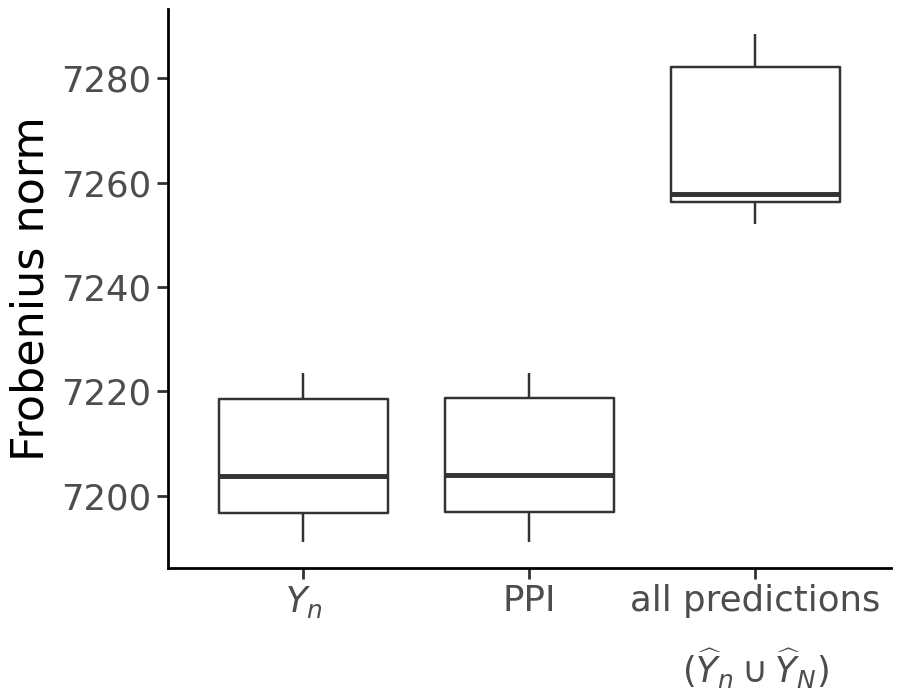

In [11]:
ggplot(d.melt(), aes(x="variable", y="value")) + \
    geom_boxplot() + \
    theme_classic(base_size=16) + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4.5,3.5)) + \
    labs(y="Frobenius norm", x="") + \
    scale_x_discrete(labels=["$Y_n$", "PPI", "all predictions\n\n$(\widehat{Y}_n \cup \widehat{Y}_N)$"])

In [64]:
p.save("comparison.png")

/home/giuliano/.local/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.5 x 3.5 in image.
/home/giuliano/.local/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: comparison.png


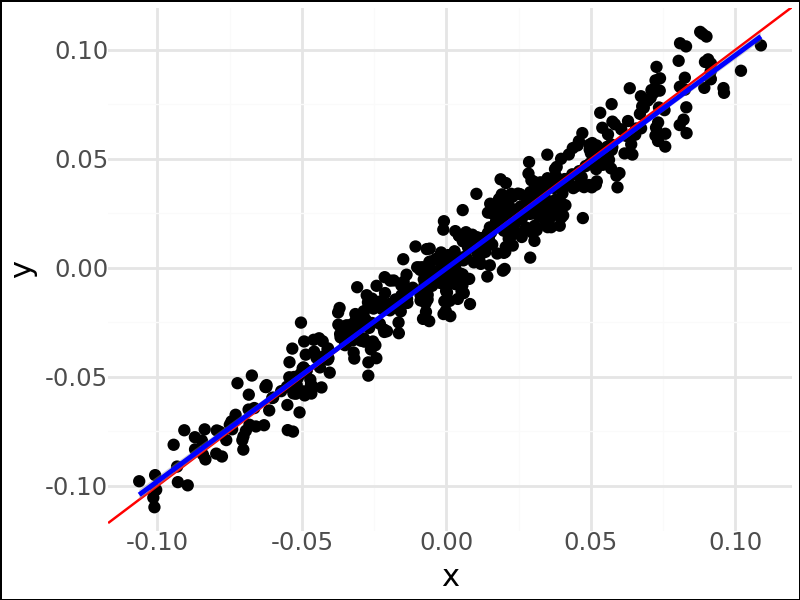

In [18]:
ggplot(
    pd.DataFrame(np.c_[W_lab[:, 1], -W_ppi[:, 1]], columns=["x", "y"]), aes(x="x", y="y")
) + \
    geom_point() + \
    geom_abline(slope=1, intercept=0, color="red") + \
    theme_minimal() + \
    theme(plot_background=element_rect(fill='white'), figure_size=(4,3)) + \
    geom_smooth(method="lm", color="blue")

In [26]:
a = ((X_lab.T @ X_lab) / n)
b = ((X_pred_lab.T @ X_pred_lab) / n)
ggplot(
    pd.DataFrame(np.c_[a[:, 1], b[:, 1]], columns=["x", "y"]), aes(x="x", y="y")
) + geom_point() + geom_smooth()
for i in range(X_lab.shape[1]):
  print(np.corrcoef(X_lab[:, i], X_pred_lab[:, i])[0, 1])

0.5116009318971246
0.2838242606150901
0.6815924920396196
0.42978052056136573
0.34953343117375935
0.506590053586421
0.22377937818203872
0.7456727263950668
-0.21729259925855593
0.4655887936454798
0.15273138277293075
0.4913636908153522
0.1437809866852554
0.402654735665936
0.2780966828531797
0.4293196033911256
-0.18493966656486924
0.7761627888378466
-0.31633878698402346
0.7174772937912931
-0.07743286434324666
0.7857081262181165
-0.1392310222947191
-0.10206788085770231
0.34346652829744523
0.540596460281831
0.023907748976689236
0.7427190007848103
0.12545600834291898
0.47826262345746434
-0.2360515809963546
0.6472245563660282
0.17124711323792693
0.39558712578792915
0.3649498229530429
0.0657866720290227
0.42312217691636644
0.5798941786159616
0.5141040853999939
0.6301283545569344
0.3960488764938289
-0.3362967337139464
0.8023686560701164
0.2044317007343129
0.626893562819672
-0.11502084080740903
0.7396009749177559
0.08066501368786314
0.6507035602147464
0.38743740842142527
0.08955855303996113
0.765

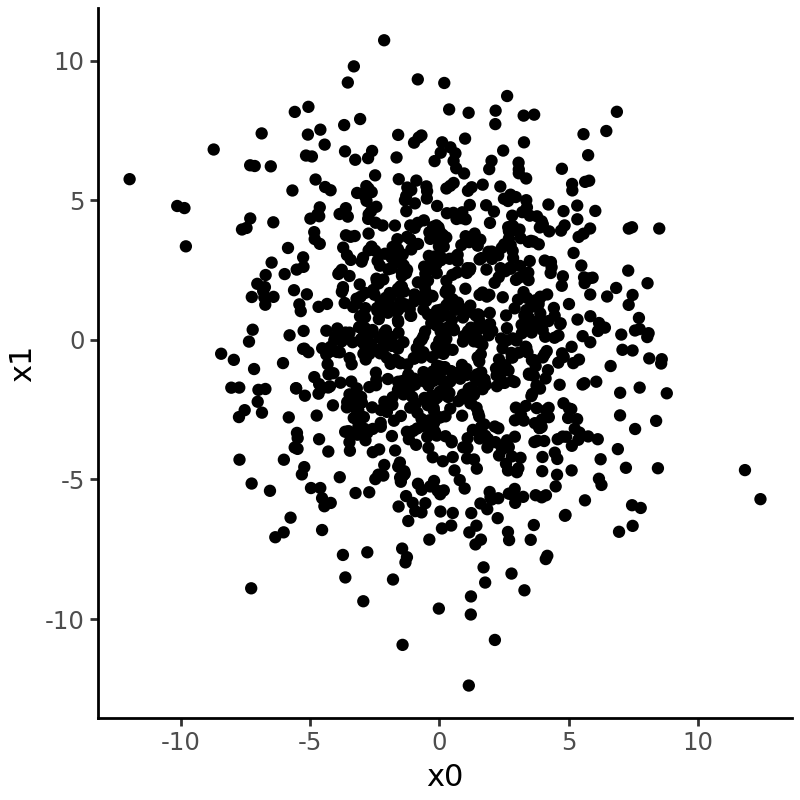

In [74]:
my_z = Z_lab[:1000, ]
ggplot(
    pd.DataFrame(my_z, columns=[f"x{i}" for i in range(my_z.shape[1])]),
    aes(x="x0", y="x1")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

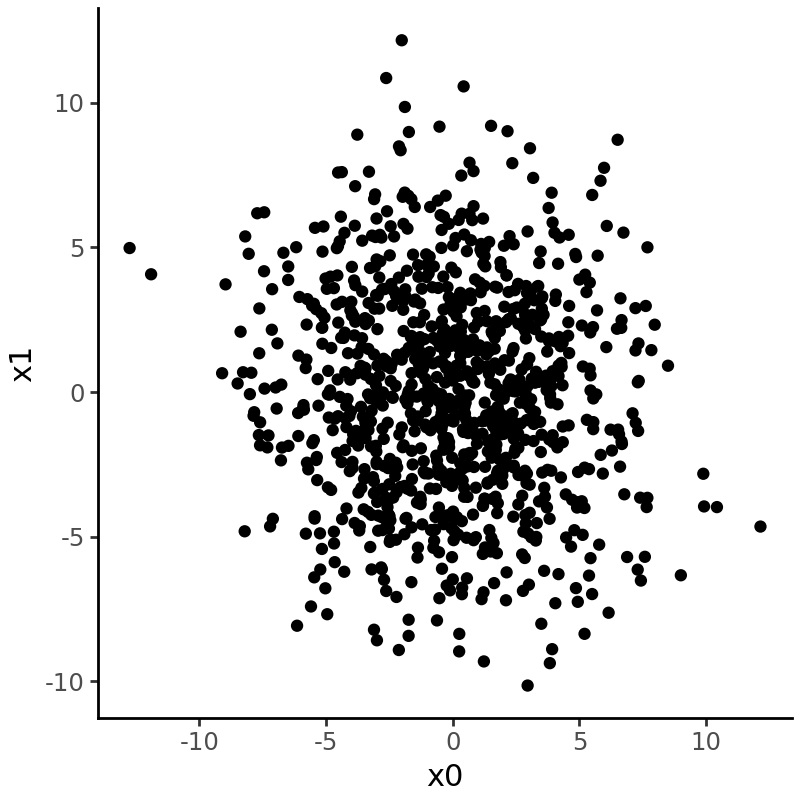

In [75]:
my_z = Z_ppi[:1000, ]
ggplot(
    pd.DataFrame(my_z, columns=[f"x{i}" for i in range(my_z.shape[1])]),
    aes(x="x0", y="x1")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

In [135]:
W_full = get_w(Sigma_full, n_comps=2)
Z_full = X_full @ W_full
Z_ppi_full = X_full @ W_ppi
Z_pred_full = X_full @ W_pred
Z_lab_full = X_full @ W_lab

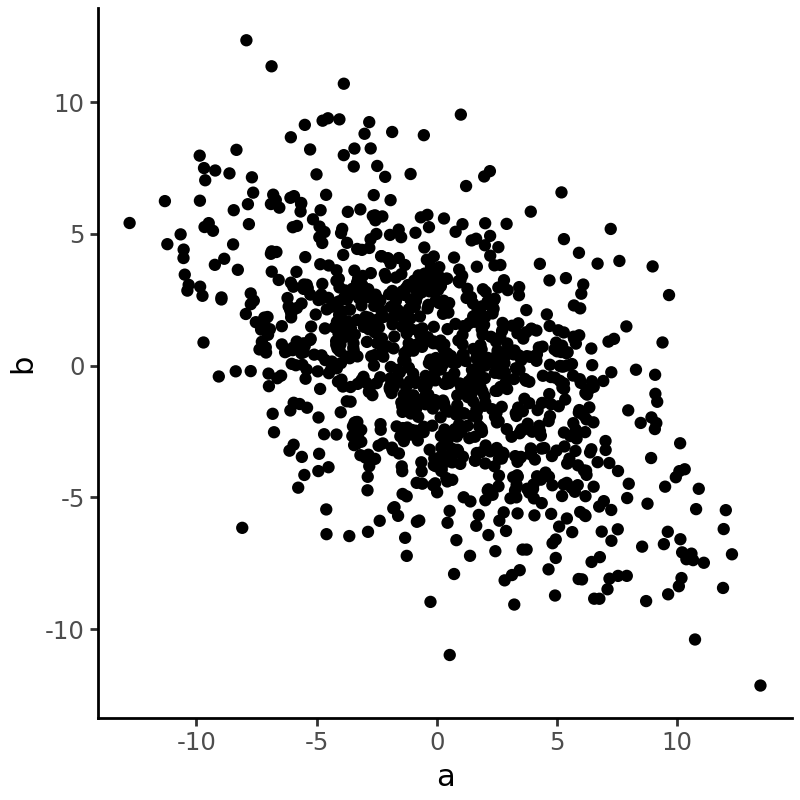

In [79]:
ggplot(
    pd.DataFrame(np.c_[Z_full[:1000, 0], Z_ppi_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

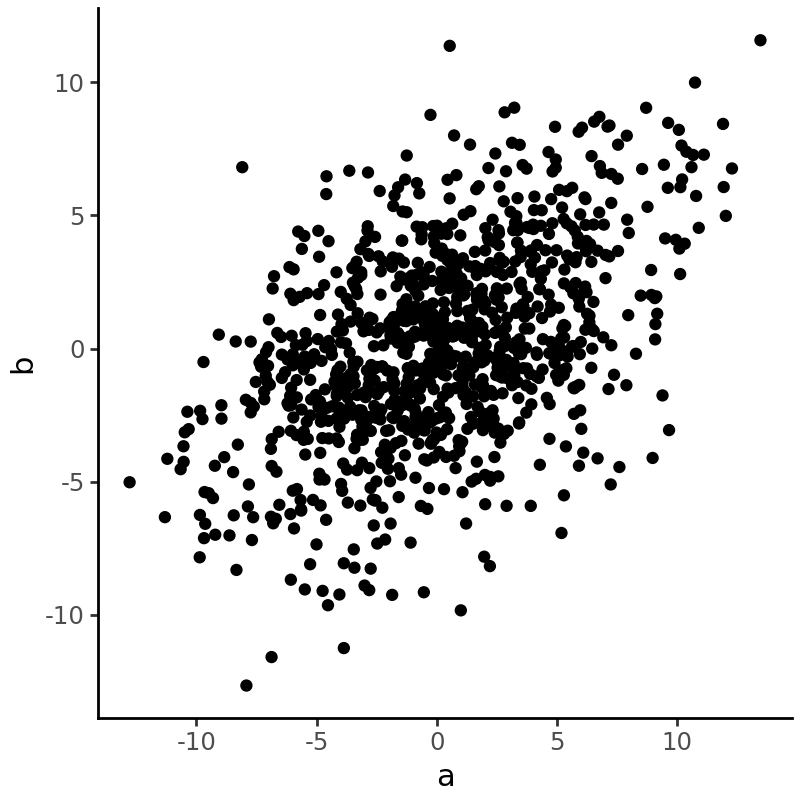

In [80]:
ggplot(
    pd.DataFrame(np.c_[Z_full[:1000, 0], Z_lab_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

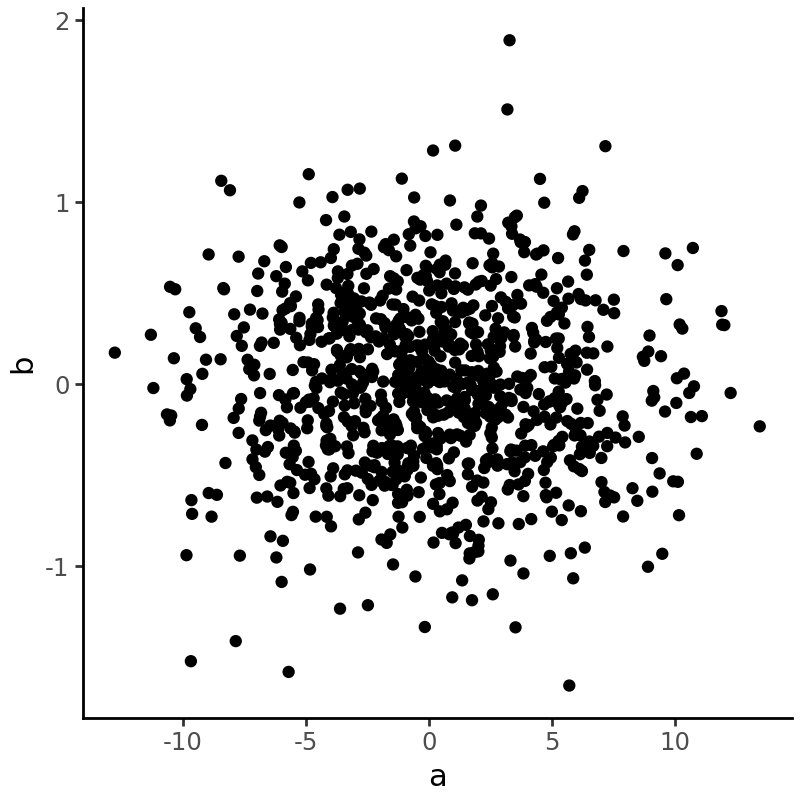

In [81]:
ggplot(
    pd.DataFrame(np.c_[Z_full[:1000, 0], Z_pred_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))

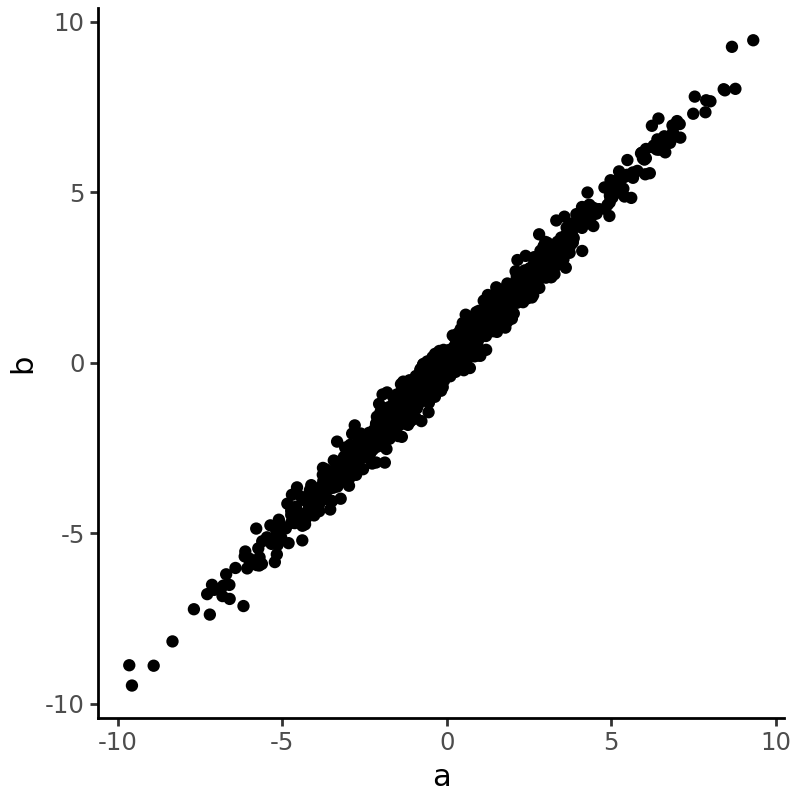

In [136]:
ggplot(
    pd.DataFrame(np.c_[Z_ppi_full[:1000, 0], Z_lab_full[:1000, 0]], columns=["a", "b"]),
    aes(x="a", y="b")
) + \
    geom_point() + \
    theme_classic() + theme(figure_size=(4, 4))